In [62]:
import mne
from mne_bids import BIDSPath, read_raw_bids
import numpy as np

### Info-Dump


- 2 Task: Regularity, Luminance
- 2 Angle: Frontoparallel, Perspective
  
- 2 Regularity: Symmetry, Asymmetry -> Discriminate symmetry from asymmetry
- 2 Luminance: Dark, Light          -> Discriminate dark from light stimuli 

Task and Angle were blocked. -> One data file per combination (Lumfron, Lumperp etc.)

- Lumfront
- LumPerp
- RegFront
- RegPerp

Events in each task: "Combination of reflection and color conditions"
- RAND_DARK
- RAND_LIGHT
- REF_DARK
- REF_LIGHT

Hypothesis of what the event types are (not 100% sure!!)
| Event label  | Likely meaning                                   | Context                           |
| ------------ | ------------------------------------------------ | --------------------------------- |
| `RAND_DARK`  | Asymmetrical (random) pattern, dark luminance    | Regularity task or Luminance task |
| `RAND_LIGHT` | Asymmetrical (random) pattern, light luminance   | ""                                |
| `REF_DARK`   | Symmetrical (reflected) pattern, dark luminance  | ""                                |
| `REF_LIGHT`  | Symmetrical (reflected) pattern, light luminance | ""                                |

In Regularity task blocks:
- Participants attend to symmetry, ignore luminance (but events still mark both features).

In Luminance task blocks:
- Participants attend to light/dark, ignore regularity (but events still mark both features).


After above tasks, this was done to check EEG data quality in VR compared to monitor (not included in hypothesis testing)
- Signalscreen  -> Monitor
- Signalvr      -> With VR headset on



### Questions

Are there only 4 events/stimuli per file/task type?? Why is it recorded for a much longer time then?

In [129]:
# read in data for a specific subject and task
bids_root = "ds005841-download"

subject_id = "001"
task = "regperp"    # lumfront, lumperp, regfront, regperp, signalscreen, signalvr -> Was ist signalscreen, signalvr?

bids_path = BIDSPath(
    subject=subject_id,
    task=task,
    datatype="eeg",
    suffix="eeg",
    extension=".bdf",
    root=bids_root
)

#print(bids_path.fpath)

raw = read_raw_bids(bids_path)
raw.load_data()

Extracting EDF parameters from d:\lisa-\Universität_2\Master\2. Semester\EEG\EEG_Project\ds005841-download\sub-001\eeg\sub-001_task-regperp_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from ds005841-download\sub-001\eeg\sub-001_task-regperp_events.tsv.
Reading 0 ... 216063  =      0.000 ...   421.998 secs...


C:\Users\lisa-\AppData\Local\Temp\ipykernel_12916\4221259201.py:18: RuntimeWarning: Did not find any channels.tsv associated with sub-001_task-regperp.

The search_str was "ds005841-download\sub-001\**\eeg\sub-001*channels.tsv"
  raw = read_raw_bids(bids_path)


<RawEDF | sub-001_task-regperp_eeg.bdf, 73 x 216064 (422.0 s), ~120.4 MiB, data loaded>

In [130]:
# get events and event id mapping
events_names, event_id = mne.events_from_annotations(raw) # only contains event-types (keep event_id for mapping of stimuli)
events = mne.find_events(raw, stim_channel="Status", initial_event=True) # actual stimuli from the "Status" channel

print("Moin ", event_id)
print(f"Found {len(events)} events")
print("Unique codes:", np.unique(events[:, 2]))

Used Annotations descriptions: [np.str_('RAND_DARK'), np.str_('RAND_LIGHT'), np.str_('REF_DARK'), np.str_('REF_LIGHT')]
Finding events on: Status
130 events found on stim channel Status
Event IDs: [    5     6     7     8    56 65536]
Moin  {np.str_('RAND_DARK'): 1, np.str_('RAND_LIGHT'): 2, np.str_('REF_DARK'): 3, np.str_('REF_LIGHT'): 4}
Found 130 events
Unique codes: [    5     6     7     8    56 65536]


In [109]:
# annotations only contain general event types, not the actual stimuli
for ann in raw.annotations: 
    print(f"{ann['description']}: onset={ann['onset']}, duration={ann['duration']}")

RAND_DARK: onset=1.5, duration=0.5
RAND_LIGHT: onset=2.0, duration=0.5
REF_DARK: onset=2.5, duration=0.5
REF_LIGHT: onset=3.0, duration=0.5


In [ ]:
#print(raw.info['ch_names'])

Sim channel = Status -> has 129 events (128 regular event + '55' event once to start off)

55 is a "junk" trigger
- This is a typical BioSemi artifact:
- 55 often appears as a status reset, button press, start packet, or Unity VR sync pulse
- It should be ignored.

The dataset does not store each trial in the .tsv.
The .tsv is only a mapping table.

In [131]:
# remove junk events (code 55)
if task == "regfront":
    valid_codes = [1,2,3,4]
    event_names = {
    1: "RAND_DARK",
    2: "RAND_LIGHT",
    3: "REF_DARK",
    4: "REF_LIGHT"
    }
elif task == "regperp":
    valid_codes = [5,6,7,8]
    event_names = {
    5: "RAND_DARK",
    6: "RAND_LIGHT",
    7: "REF_DARK",
    8: "REF_LIGHT"
    }
elif task == "lumfront":
    valid_codes = [11,12,13,14]
    event_names = {
    11: "RAND_DARK",
    12: "RAND_LIGHT",
    13: "REF_DARK",
    14: "REF_LIGHT"
    }
elif task == "lumperp":
    valid_codes = [15,16,17,18]
    event_names = {
    15: "RAND_DARK",
    16: "RAND_LIGHT",
    17: "REF_DARK",
    18: "REF_LIGHT"
    }
else:
    print("help")

print("Valid codes:", valid_codes)
clean_events = events[np.isin(events[:, 2], valid_codes)]
#event_names = {v: k for k, v in event_id.items()} # idk but needs inverted mapping
#print(event_names)

# correctly annotate: 
annotations = mne.annotations_from_events(
    events=clean_events,
    event_desc=event_names,      
    sfreq=raw.info["sfreq"]
)

raw.set_annotations(annotations)

Valid codes: [5, 6, 7, 8]


<RawEDF | sub-001_task-regperp_eeg.bdf, 73 x 216064 (422.0 s), ~120.4 MiB, data loaded>

{np.str_('RAND_DARK'): 1, np.str_('RAND_LIGHT'): 2, np.str_('REF_DARK'): 3, np.str_('REF_LIGHT'): 4}


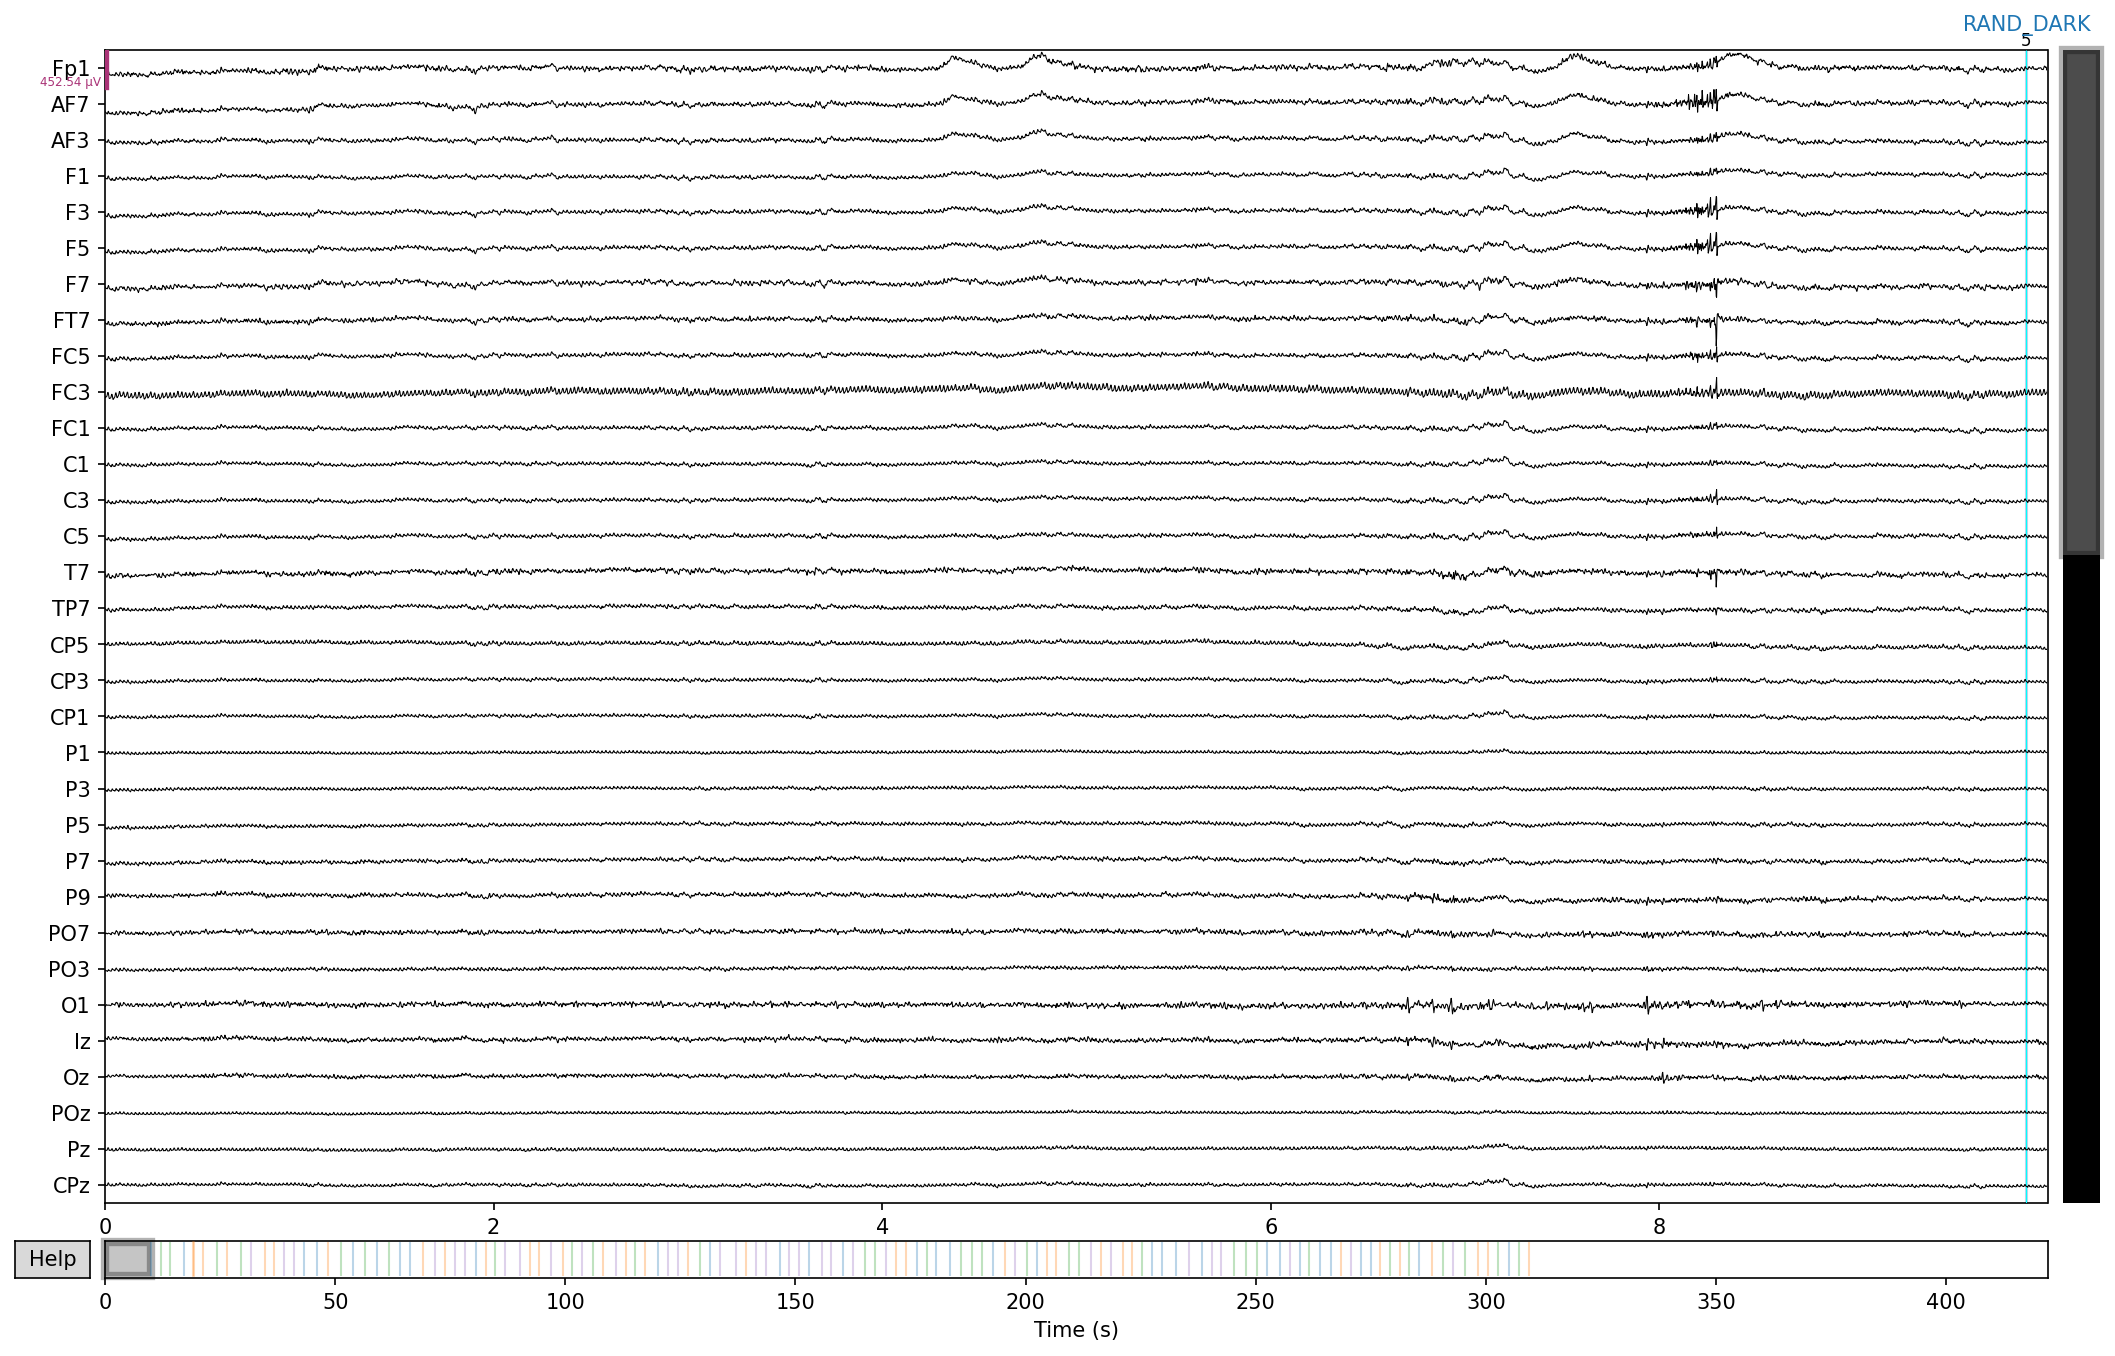

Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
%matplotlib qt
print(event_id)
raw.plot(
    events=clean_events,
    #event_id=event_id,
    #event_color={"RAND_DARK": "blue", "RAND_LIGHT": "orange",
    #             "REF_DARK": "green", "REF_LIGHT": "purple"},
    duration=10,
    scalings="auto",
    n_channels=32,
    #block=True
)

In [ ]:
%matplotlib inline
#fig = mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info["sfreq"], first_samp=raw.first_samp)

ValueError: 1 from event_id is not present in events.

In [ ]:
# now: correctly annotated stimuli
for ann in raw.annotations: 
    print(f"{ann['description']}: onset={ann['onset']}, duration={ann['duration']}")

RAND_LIGHT: onset=8.205078, duration=0.0
REF_LIGHT: onset=10.707031, duration=0.0
REF_DARK: onset=13.152344, duration=0.0
RAND_DARK: onset=15.841797, duration=0.0
RAND_DARK: onset=36.095703, duration=0.0
RAND_LIGHT: onset=39.210938, duration=0.0
REF_LIGHT: onset=41.613281, duration=0.0
REF_DARK: onset=45.5, duration=0.0
RAND_LIGHT: onset=48.044922, duration=0.0
REF_DARK: onset=50.369141, duration=0.0
REF_LIGHT: onset=52.570312, duration=0.0
REF_DARK: onset=54.916016, duration=0.0
REF_DARK: onset=57.919922, duration=0.0
REF_LIGHT: onset=60.064453, duration=0.0
RAND_DARK: onset=62.466797, duration=0.0
REF_DARK: onset=64.576172, duration=0.0
REF_LIGHT: onset=66.876953, duration=0.0
RAND_DARK: onset=69.111328, duration=0.0
RAND_LIGHT: onset=71.3125, duration=0.0
REF_LIGHT: onset=73.511719, duration=0.0
REF_LIGHT: onset=75.601562, duration=0.0
RAND_DARK: onset=77.802734, duration=0.0
RAND_LIGHT: onset=79.869141, duration=0.0
REF_LIGHT: onset=82.001953, duration=0.0
RAND_DARK: onset=86.03320